In [1]:
import pandas as pd
import numpy
from matplotlib import pyplot as plt
from typing import List, Dict
from collections import Counter
from pprint import pprint

import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("mako")

import spacy
from spacy.lang.en import English
from nltk.corpus import stopwords

nlp = English()

pd.set_option('display.float_format', '{:.2f}'.format)
# sns.color_palette("rocket", as_cmap=True)

2023-06-15 21:45:58.717469: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_raw = pd.read_parquet("/Users/luis.morales/Desktop/arxiv-paper-recommender/data/processed/arxiv_papers_raw.parquet.gzip")

In [3]:
df_raw

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'created': 'Mon, 2 Apr 2007 19:18:42 GMT', '...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'created': 'Sat, 31 Mar 2007 02:26:18 GMT', ...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'created': 'Sun, 1 Apr 2007 20:46:54 GMT', '...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'created': 'Sat, 31 Mar 2007 03:16:14 GMT', ...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'created': 'Mon, 2 Apr 2007 18:09:58 GMT', '...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268247,supr-con/9608008,Ruslan Prozorov,"R. Prozorov, M. Konczykowski, B. Schmidt, Y. Y...",On the origin of the irreversibility line in t...,"19 pages, LaTex, 6 PostScript figures; Author'...",None,10.1103/PhysRevB.54.15530,None,supr-con cond-mat.supr-con,None,We report on measurements of the angular dep...,"[{'created': 'Mon, 26 Aug 1996 15:08:35 GMT', ...",2009-10-30,"[[Prozorov, R., ], [Konczykowski, M., ], [Schm..."
2268248,supr-con/9609001,Durga P. Choudhury,"Durga P. Choudhury, Balam A. Willemsen, John S...",Nonlinear Response of HTSC Thin Film Microwave...,"4 pages, LaTeX type, Uses IEEE style files, 60...",None,10.1109/77.620744,None,supr-con cond-mat.supr-con,None,The non-linear microwave surface impedance o...,"[{'created': 'Sat, 31 Aug 1996 17:34:38 GMT', ...",2016-11-18,"[[Choudhury, Durga P., , Physics Department, N..."
2268249,supr-con/9609002,Durga P. Choudhury,"Balam A. Willemsen, J. S. Derov and S.Sridhar ...",Critical State Flux Penetration and Linear Mic...,"20 pages, LaTeX type, Uses REVTeX style files,...",None,10.1103/PhysRevB.56.11989,None,supr-con cond-mat.supr-con,None,The vortex contribution to the dc field (H) ...,"[{'created': 'Tue, 3 Sep 1996 14:08:26 GMT', '...",2009-10-30,"[[Willemsen, Balam A., , Physics Department,\n..."
2268250,supr-con/9609003,Hasegawa Yasumasa,Yasumasa Hasegawa (Himeji Institute of Technol...,Density of States and NMR Relaxation Rate in A...,"7 pages, 4 PostScript Figures, LaTeX, to appea...",None,10.1143/JPSJ.65.3131,None,supr-con cond-mat.supr-con,None,We show that the density of states in an ani...,"[{'created': 'Wed, 18 Sep 1996 07:57:29 GMT', ...",2009-10-30,"[[Hasegawa, Yasumasa, , Himeji Institute of Te..."


### Metadata
This dataset is a mirror of the original ArXiv data. Because the full dataset is rather large (1.1TB and growing), this dataset provides only a metadata file in the json format. This file contains an entry for each paper, containing:

- id: ArXiv ID (can be used to access the paper, see below)
- submitter: Who submitted the paper
- authors: Authors of the paper
- title: Title of the paper
- comments: Additional info, such as number of pages and figures
- journal-ref: Information about the journal the paper was published in
- doi: [https://www.doi.org](Digital Object Identifier)
- abstract: The abstract of the paper
- categories: Categories / tags in the ArXiv system
- versions: A version history


### Utility functions

In [4]:
def creating_box_hist(column: str, df: pd.DataFrame, plot_title: str):
    """
    Function to create a combined box plot and histogram for a column in a DataFrame.

    Parameters:
    - column (str): Name of the column in the DataFrame to visualize.
    - df (DataFrame): Input DataFrame containing the data.
    - plot_title (str): Title for the combined plot.
    """    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})    

    sns.boxplot(x=df[column], ax=ax_box)
    sns.histplot(data=df, x=column, ax=ax_hist)

    ax_box.set(xlabel='')
    plt.title(plot_title)
    plt.show()

In [5]:
def plot_paper_release_year(df: pd.DataFrame, category: str = '', date_col: str = "update_date", save_plot: bool = False):
    """
    Generate a line plot to visualize the counts of papers released over time.

    Args:
        df (pd.DataFrame): The input DataFrame containing the paper data.
            It should have a column named `update_date` representing the release date of each paper.
        date_col (str): The name of the column in the DataFrame `df` that contains the release dates.
    """
    df_date = df[[date_col]].copy()
    df_date['month_year'] = df_date['update_date'].dt.to_period('Y')
    monthly_counts = df_date['month_year'].value_counts().to_frame().reset_index() \
        .sort_values(by='month_year', ascending=True)

    plot_name = f'Numero de papers de {category} publicados por año'
    sns.lineplot(x=monthly_counts['month_year'].astype(str), y=monthly_counts['count'])
    plt.xlabel('Año')
    plt.ylabel('Conteo')
    plt.title(plot_name)
    plt.xticks(rotation=45)

    if save_plot:
        # Create the directory if it doesn't exist
        save_path = f"/Users/luis.morales/Desktop/arxiv-paper-recommender/reports/Visualizations/Papes_release_year_by_{category}.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
    else:
        plt.show()

In [6]:
df_raw.iloc[206,:]["categories"]

'astro-ph gr-qc nucl-th'

## EDA

In [7]:
df_raw

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'created': 'Mon, 2 Apr 2007 19:18:42 GMT', '...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'created': 'Sat, 31 Mar 2007 02:26:18 GMT', ...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'created': 'Sun, 1 Apr 2007 20:46:54 GMT', '...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'created': 'Sat, 31 Mar 2007 03:16:14 GMT', ...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'created': 'Mon, 2 Apr 2007 18:09:58 GMT', '...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268247,supr-con/9608008,Ruslan Prozorov,"R. Prozorov, M. Konczykowski, B. Schmidt, Y. Y...",On the origin of the irreversibility line in t...,"19 pages, LaTex, 6 PostScript figures; Author'...",None,10.1103/PhysRevB.54.15530,None,supr-con cond-mat.supr-con,None,We report on measurements of the angular dep...,"[{'created': 'Mon, 26 Aug 1996 15:08:35 GMT', ...",2009-10-30,"[[Prozorov, R., ], [Konczykowski, M., ], [Schm..."
2268248,supr-con/9609001,Durga P. Choudhury,"Durga P. Choudhury, Balam A. Willemsen, John S...",Nonlinear Response of HTSC Thin Film Microwave...,"4 pages, LaTeX type, Uses IEEE style files, 60...",None,10.1109/77.620744,None,supr-con cond-mat.supr-con,None,The non-linear microwave surface impedance o...,"[{'created': 'Sat, 31 Aug 1996 17:34:38 GMT', ...",2016-11-18,"[[Choudhury, Durga P., , Physics Department, N..."
2268249,supr-con/9609002,Durga P. Choudhury,"Balam A. Willemsen, J. S. Derov and S.Sridhar ...",Critical State Flux Penetration and Linear Mic...,"20 pages, LaTeX type, Uses REVTeX style files,...",None,10.1103/PhysRevB.56.11989,None,supr-con cond-mat.supr-con,None,The vortex contribution to the dc field (H) ...,"[{'created': 'Tue, 3 Sep 1996 14:08:26 GMT', '...",2009-10-30,"[[Willemsen, Balam A., , Physics Department,\n..."
2268250,supr-con/9609003,Hasegawa Yasumasa,Yasumasa Hasegawa (Himeji Institute of Technol...,Density of States and NMR Relaxation Rate in A...,"7 pages, 4 PostScript Figures, LaTeX, to appea...",None,10.1143/JPSJ.65.3131,None,supr-con cond-mat.supr-con,None,We show that the density of states in an ani...,"[{'created': 'Wed, 18 Sep 1996 07:57:29 GMT', ...",2009-10-30,"[[Hasegawa, Yasumasa, , Himeji Institute of Te..."


In [8]:
null_counts = df_raw.isnull().sum()
null_df = pd.DataFrame(null_counts, columns=['Null Count'])
null_df

,Null Count
id,0
submitter,15188
authors,0
title,0
comments,533142
journal-ref,1464835
doi,1146890
report-no,2092748
categories,0
license,452843


In [9]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2268252 entries, 0 to 2268251
Data columns (total 14 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   id              object
 1   submitter       object
 2   authors         object
 3   title           object
 4   comments        object
 5   journal-ref     object
 6   doi             object
 7   report-no       object
 8   categories      object
 9   license         object
 10  abstract        object
 11  versions        object
 12  update_date     object
 13  authors_parsed  object
dtypes: object(14)
memory usage: 242.3+ MB


In [10]:
df_raw["update_date"] = pd.to_datetime(df_raw["update_date"])

In [11]:
def split_text_column_by_separator(df_col: pd.Series, sep: str = ' ') -> List:
     """
     Splits the entries in a pandas Series column by a specified separator and returns a list of the split values.

     Parameters:
          - df_col (pd.Series): The pandas Series column to split.
          - sep (str): The separator used to split the entries (default is a space ' ').
     """
     complete_lst = []
     column_list = df_col.to_list()
     for entry in column_list:
          complete_lst.extend(entry.split(sep))
     return complete_lst

### Analysis for Categories

In [12]:
total_categories_count = split_text_column_by_separator(df_raw['categories'])
len(total_categories_count)

3822992

Notice our dataset has data from 2,268,252 papers, and each paper has either one or more categories associated, if we split all the catgories and count them we have 3,822,992 categories.

Take a look to the Category Taxonomy here: https://arxiv.org/category_taxonomy

In [13]:
total_count_of_cats

NameError: name 'total_count_of_cats' is not defined

In [ ]:
total_count_of_cats = dict(Counter(total_categories_count))

In [ ]:

def consolidate_cat_count(count_of_subcategories: Dict[str, int]):
    parent_categories = ['cs', 'acc-phys', 'funct-an', 'ao-sci', 'math-ph', 'adap-org', 'supr-con', 'bayes-an', 
                         'patt-sol', 'comp-gas', 'dg-ga','quant-ph', 'hep-lat', 'nucl-ex', 'physics', 'plasm-ph', 
                         'q-alg', 'cmp-lg', 'eess', 'hep-ex', 'q-bio', 'gr-qc', 'solv-int', 'math', 'nucl-th', 
                         'chao-dyn', 'q-fin', 'alg-geom', 'chem-ph', 'hep-ph', 'astro-ph', 'atom-ph', 'nlin', 
                         'mtrl-th', 'hep-th', 'econ', 'cond-mat','stat']
    consolidate = {cat: 0 for cat in parent_categories}

    for key, value in count_of_subcategories.items():
        if '.' in key:
            _key = key.split(".")[0]
            consolidate[_key] += value
        else:
            consolidate[key] += value
    return consolidate
category_consolidate = consolidate_cat_count(total_count_of_cats)
category_consolidate 


{'cs': 762856,
 'acc-phys': 49,
 'funct-an': 427,
 'ao-sci': 17,
 'math-ph': 74415,
 'adap-org': 584,
 'supr-con': 175,
 'bayes-an': 16,
 'patt-sol': 650,
 'comp-gas': 221,
 'dg-ga': 732,
 'quant-ph': 135474,
 'hep-lat': 26742,
 'nucl-ex': 24385,
 'physics': 282299,
 'plasm-ph': 38,
 'q-alg': 1578,
 'cmp-lg': 894,
 'eess': 69622,
 'hep-ex': 50483,
 'q-bio': 47771,
 'gr-qc': 100320,
 'solv-int': 1413,
 'math': 809731,
 'nucl-th': 54353,
 'chao-dyn': 2398,
 'q-fin': 20906,
 'alg-geom': 1423,
 'chem-ph': 251,
 'hep-ph': 172043,
 'astro-ph': 385477,
 'atom-ph': 123,
 'nlin': 43609,
 'mtrl-th': 262,
 'hep-th': 158585,
 'econ': 8007,
 'cond-mat': 456374,
 'stat': 128289}

In [ ]:
def augment_subject_of_categories(categories_dict: Dict[str, int]):
    categories_taxonomy = {
        'cs': 'Computer Science',
        'econ': 'Economics',
        'eess': 'Electrical Engineering and Systems Science',
        'math': 'Mathematics',
        'astro-ph': 'Physics - Astrophysics',
        'cond-mat': 'Physics - Condensed Matter',
        'gr-qc': 'Physics - General Relativity And Quantum Cosmology',
        'hep-ex': 'Physics - High Enery Physics - Expetiment',
        'hep-lat': 'Physics - High Enery Physics - Lattice',
        'hep-ph': 'Physics - High Enery Physics - Phenomenology',
        'hep-th': 'Physics - High Enery Physics - Theory',
        'math-ph': 'Physics - Mathematical Physics',
        'nlin': 'Physics - Nonlinear Sciences',
        'nucl-ex': 'Physics - Nuclear Experiment',
        'nucl-th': 'Physics - Nuclear Theory',
        'physics': 'Physics - General Physics',
        'quant-ph': 'Physics - Quantum Physics',
        'q-bio': 'Quantitative Biology',
        'q-fin': 'Quantitative Finance',
        'stat': 'Statistics'
    }
    for key, count in categories_dict.items():
        if key in categories_taxonomy:
            categories_dict[key] = {
                "count": count,
                "Science": categories_taxonomy[key]
            }
        else :
            categories_dict[key] = {
                "count": count,
                "Science": f"{key} - NOT FOUND"
            }
    return categories_dict


In [ ]:
category_consolidate

{'cs': 762856,
 'acc-phys': 49,
 'funct-an': 427,
 'ao-sci': 17,
 'math-ph': 74415,
 'adap-org': 584,
 'supr-con': 175,
 'bayes-an': 16,
 'patt-sol': 650,
 'comp-gas': 221,
 'dg-ga': 732,
 'quant-ph': 135474,
 'hep-lat': 26742,
 'nucl-ex': 24385,
 'physics': 282299,
 'plasm-ph': 38,
 'q-alg': 1578,
 'cmp-lg': 894,
 'eess': 69622,
 'hep-ex': 50483,
 'q-bio': 47771,
 'gr-qc': 100320,
 'solv-int': 1413,
 'math': 809731,
 'nucl-th': 54353,
 'chao-dyn': 2398,
 'q-fin': 20906,
 'alg-geom': 1423,
 'chem-ph': 251,
 'hep-ph': 172043,
 'astro-ph': 385477,
 'atom-ph': 123,
 'nlin': 43609,
 'mtrl-th': 262,
 'hep-th': 158585,
 'econ': 8007,
 'cond-mat': 456374,
 'stat': 128289}

In [ ]:
consolidated_list = [[key, value] for key, value in category_consolidate.items()]
count_cats_df = pd.DataFrame.from_records(consolidated_list, columns=['Subject', 'count_categories']) \
                .sort_values(by='count_categories', ascending=False) \
                .reset_index(drop=True)
count_cats_df.head(10)

,Subject,count_categories
0,math,809731
1,cs,762856
2,cond-mat,456374
3,astro-ph,385477
4,physics,282299
5,hep-ph,172043
6,hep-th,158585
7,quant-ph,135474
8,stat,128289
9,gr-qc,100320


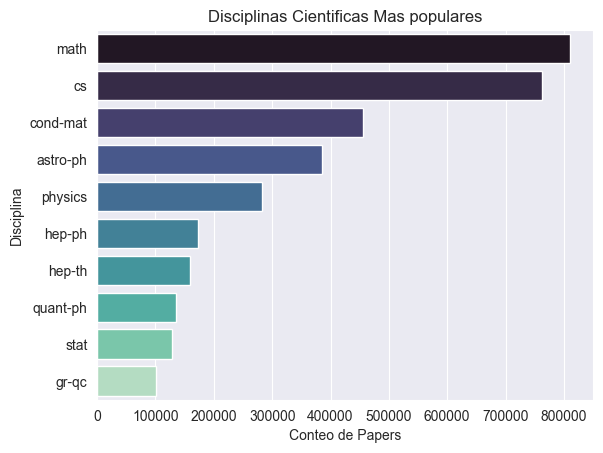

In [ ]:
sns.barplot(x='count_categories', y='Subject', data=count_cats_df.nlargest(10, 'count_categories'), palette="mako")

plt.xlabel('Conteo de Papers')
plt.ylabel('Disciplina')
plt.title('Disciplinas Cientificas Mas populares')
plt.show()

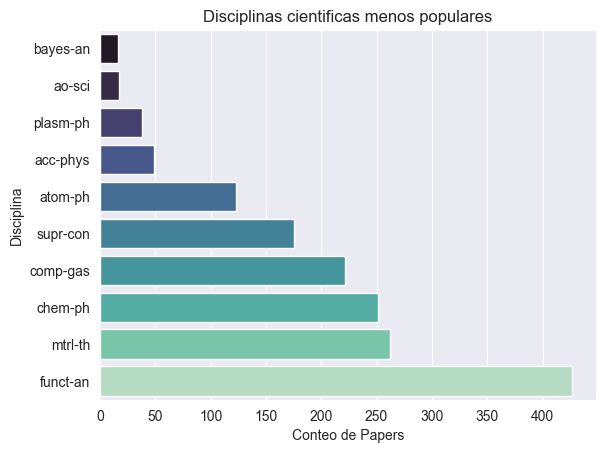

In [ ]:
sns.barplot(x='count_categories', y='Subject', 
            data=count_cats_df.nsmallest(10, 'count_categories'),
            palette="mako")

plt.xlabel('Conteo de Papers')
plt.ylabel('Disciplina')
plt.title('Disciplinas cientificas menos populares')
plt.show()

### Abstract Analysis


In [ ]:
df_raw['len_abstract'] =  df_raw['abstract'].str.len()
df_raw.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,len_abstract
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'created': 'Mon, 2 Apr 2007 19:18:42 GMT', '...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...",983
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'created': 'Sat, 31 Mar 2007 02:26:18 GMT', ...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",798
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'created': 'Sun, 1 Apr 2007 20:46:54 GMT', '...",2008-01-13,"[[Pan, Hongjun, ]]",880
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'created': 'Sat, 31 Mar 2007 03:16:14 GMT', ...",2007-05-23,"[[Callan, David, ]]",248
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'created': 'Mon, 2 Apr 2007 18:09:58 GMT', '...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]",223


In [ ]:
df_raw[['len_abstract']].describe()

,len_abstract
count,2268252.00
mean,935.27
std,427.57
min,6.00
25%,605.00
50%,894.00
75%,1233.00
max,6091.00


In [ ]:
q1, q3 = df_raw['len_abstract'].quantile(0.25), df_raw['len_abstract'].quantile(0.75)
iqr = q3 - q1
iqr

628.0

**Key points of Summary Statistics:**
- Notice the `Min lenght` is 6 while `Max lenght` is 6091. 
- The Mean is `935.27`, while the median `894.00`. Does this suggest our distribution is kind of Symetrical?
- We have high variance in our data, as the std is `427.57`
- The `IQR` is 628.0
- Our distribution is very disperse, as we have most of the count values < 2000, and very litle with more than 2000 characters.

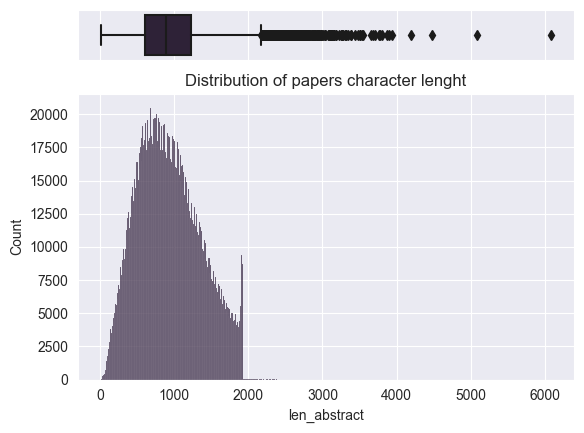

In [ ]:
creating_box_hist(column='len_abstract', df=df_raw, plot_title='Distribution of papers character lenght')

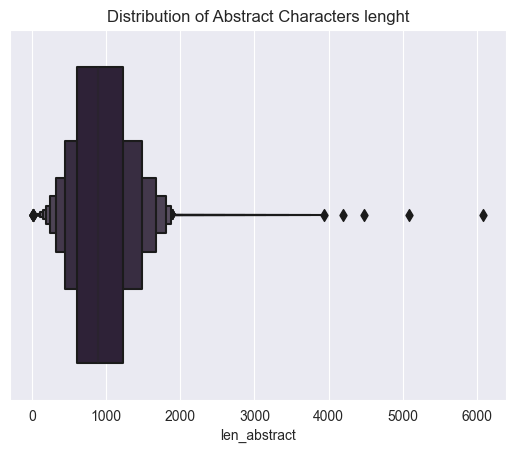

In [ ]:
sns.boxenplot(x=df_raw['len_abstract'])
plt.title("Distribution of Abstract Characters lenght")
plt.show()

Lets analyze the papers that does have either more than 2000 characters and less than 2000 chars.

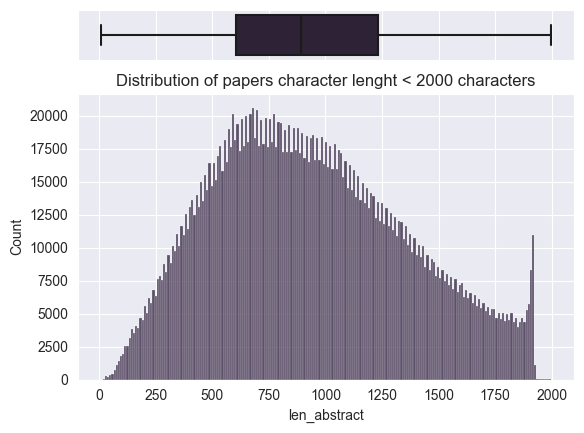

In [ ]:
lt_condition = (df_raw['len_abstract'] < 2000) 
creating_box_hist(column='len_abstract', 
                  df=df_raw[['len_abstract']][lt_condition], 
                  plot_title='Distribution of papers character lenght < 2000 characters')

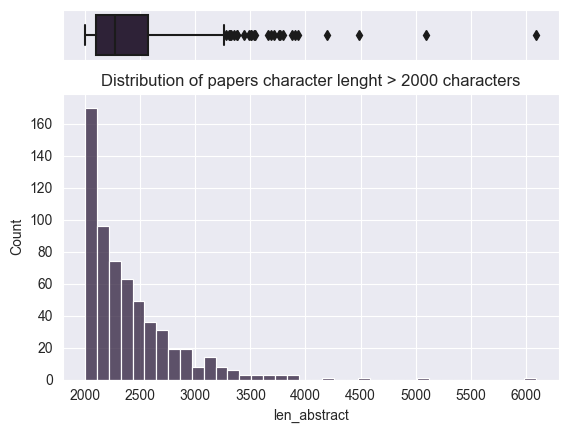

In [ ]:
gt_condition = (df_raw['len_abstract'] > 2000) 
creating_box_hist(column='len_abstract', 
                  df=df_raw[['len_abstract']][gt_condition], 
                  plot_title='Distribution of papers character lenght > 2000 characters')


### Release Date Analysis


Lets analyze the papers by release year

In [ ]:
df_raw['month_year'] = df_raw['update_date'].dt.to_period('Y')
monthly_counts = df_raw['month_year'].value_counts().to_frame().reset_index() \
    .sort_values(by='month_year', ascending=True) \
    .reset_index(drop=True)
monthly_counts



,month_year,count
0,2007,145936
1,2008,69357
2,2009,229079
3,2010,56229
4,2011,61870
5,2012,57324
6,2013,72037
7,2014,88141
8,2015,215153
9,2016,133658


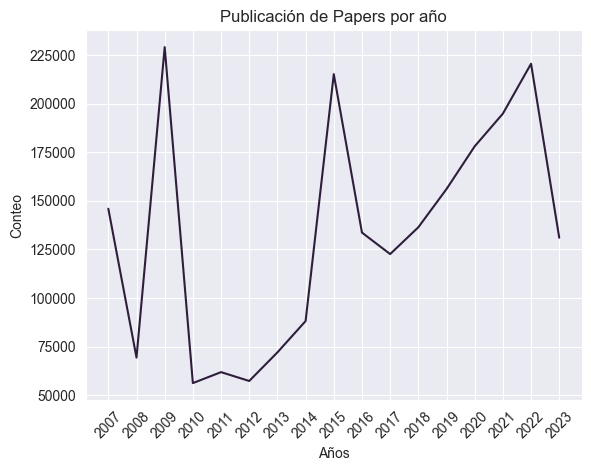

In [ ]:
sns.lineplot(x=monthly_counts['month_year'].astype(str), y=monthly_counts['count'])
plt.xlabel('Años')
plt.ylabel('Conteo')
plt.title('Publicación de Papers por año')
plt.xticks(rotation=45)
plt.show()


In [ ]:
count_cats_df.nlargest(5, 'Count_papers')

,Subject,Count_papers
0,math,809731
1,cs,762856
2,cond-mat,456374
3,astro-ph,385477
4,physics,282299


In [ ]:
cs_df = df_raw[df_raw['categories'].str.contains('cs')]
economics_df = df_raw[df_raw['categories'].str.contains('econ')]
eess_df = df_raw[df_raw['categories'].str.contains('eess')]
math_df = df_raw[df_raw['categories'].str.contains('math')]
physics_df = df_raw[df_raw['categories'].str.contains('physics')]
q_bio_df = df_raw[df_raw['categories'].str.contains('q-bio')]
q_fin_df = df_raw[df_raw['categories'].str.contains('q-fin')]
stat_df = df_raw[df_raw['categories'].str.contains('stat')]

total_dfs = [
    (cs_df, "Computer Science"), 
    (economics_df, "Economics"), 
    (eess_df, "Electrical Engineering and Systems Science"),
    (math_df, "Mathematics"), 
    (physics_df, "Physics"), 
    (q_bio_df, "Quantitative Biology"), 
    (q_fin_df, "Quantitative Finance"), 
    (stat_df, "Statistics")
]


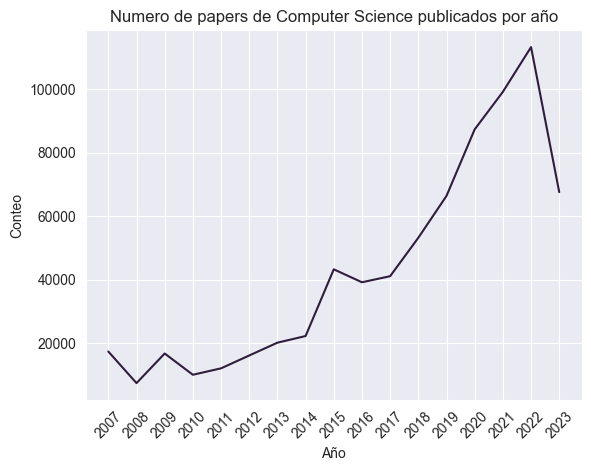

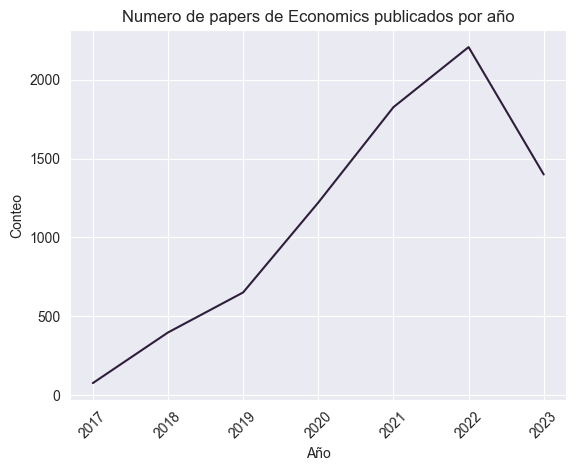

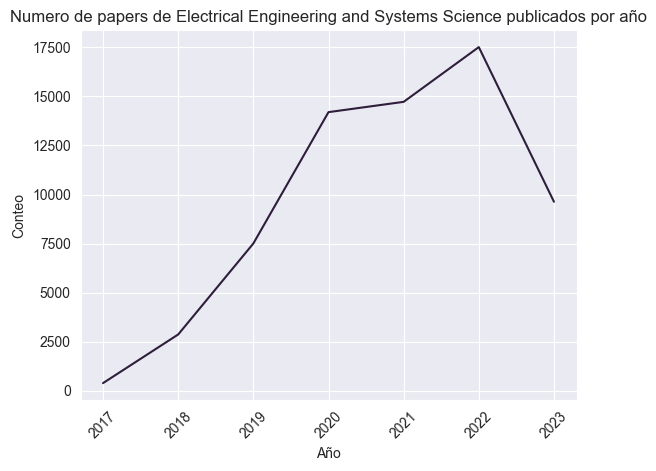

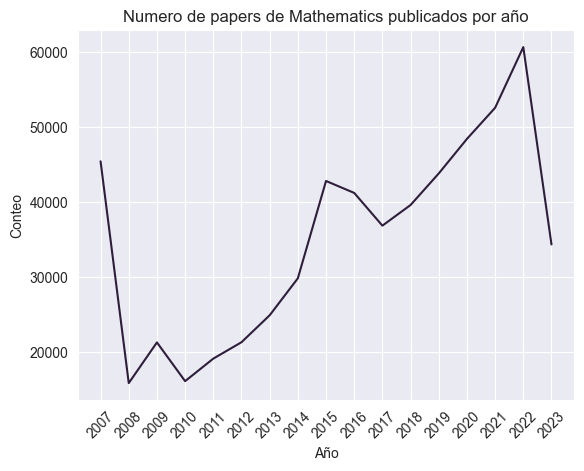

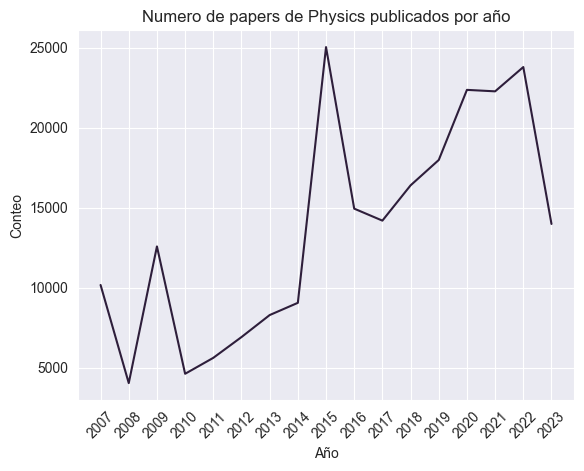

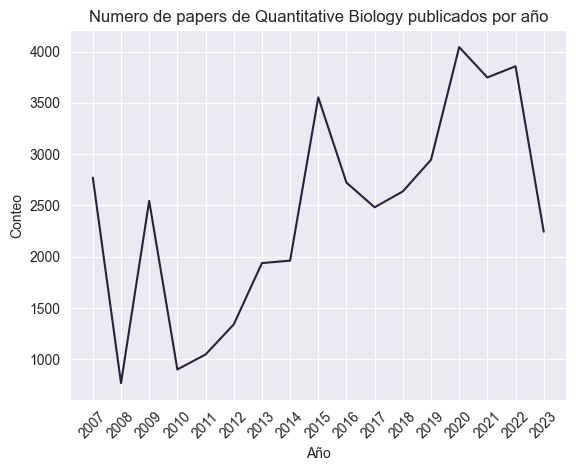

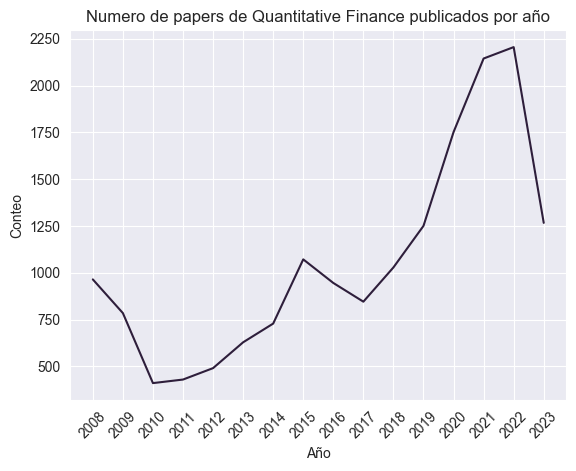

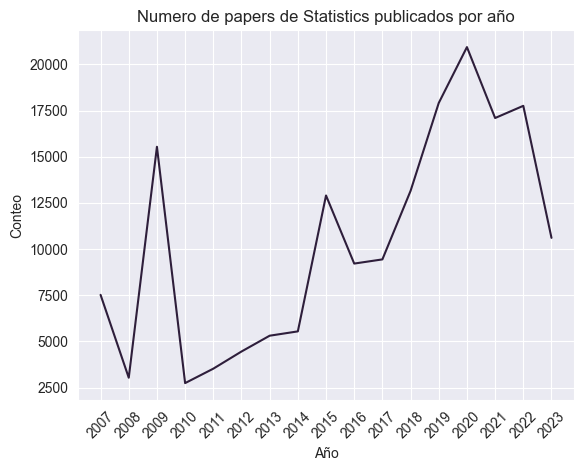

In [ ]:
for category in total_dfs:
    plot_paper_release_year(df=category[0], category=category[1], save_plot=True)

### NLP EDA


As analyzing all the corpus of data we have requieres much computational power, for local developlment we will do the analysis with only 20000 rows of the Daataframe, for the running the full analysis in SageMaker.

In [ ]:
# nlp_df = df_raw.copy()
nlp_df = df_raw.sample(20000).reset_index(drop=True)
nlp_corpus = nlp_df["abstract"].to_list()
nlp_corpus[:3]

['  A Comment by R. Blumenfeld on our recent analytical solution for the random\nclose packing density [A. Zaccone, Phys. Rev. Lett. 128, 028002 (2022)] is\nshown to be plagued by important errors and to contain incorrect statements.\n',
 '  In the past decades, determinants and Pfaffians were found for eigenvalue\ncorrelations of various random matrix ensembles. These structures simplify the\naverage over a large number of ratios of characteristic polynomials to\nintegrations over one and two characteristic polynomials only. Up to now it was\nthought that determinants occur for ensembles with Dyson index $\\beta=2$\nwhereas Pfaffians only for ensembles with $\\beta=1,4$. We derive a non-trivial\nPfaffian determinant for $\\beta=2$ random matrix ensembles which is similar to\nthe one for $\\beta=1,4$. Thus, it unveils a hidden universality of this\nstructure. We also give a general relation between the orthogonal polynomials\nrelated to the determinantal structure and the skew-orthogon

In [ ]:
corpus_nlp = list(nlp.pipe(nlp_corpus))
corpus_nlp

[  A Comment by R. Blumenfeld on our recent analytical solution for the random
 close packing density [A. Zaccone, Phys. Rev. Lett. 128, 028002 (2022)] is
 shown to be plagued by important errors and to contain incorrect statements.,
   In the past decades, determinants and Pfaffians were found for eigenvalue
 correlations of various random matrix ensembles. These structures simplify the
 average over a large number of ratios of characteristic polynomials to
 integrations over one and two characteristic polynomials only. Up to now it was
 thought that determinants occur for ensembles with Dyson index $\beta=2$
 whereas Pfaffians only for ensembles with $\beta=1,4$. We derive a non-trivial
 Pfaffian determinant for $\beta=2$ random matrix ensembles which is similar to
 the one for $\beta=1,4$. Thus, it unveils a hidden universality of this
 structure. We also give a general relation between the orthogonal polynomials
 related to the determinantal structure and the skew-orthogonal polyno

In [ ]:
def generate_ngrams(df, column_name, n):
    ngrams = []
    for text in df[column_name]:
        doc = nlp(text)
        for i in range(len(doc) - n + 1):
            ngram = doc[i:i + n]
            ngrams.append(' '.join(token.text for token in ngram))
    return ngrams

In [ ]:
one_grams = generate_ngrams(nlp_df, 'abstract', 1)


In [ ]:
def generate_ngrams(text, n):
    doc = nlp(text)
    ngrams = []
    for i in range(len(doc) - n + 1):
        ngram = doc[i:i + n]
        ngrams.append(' '.join(token.text for token in ngram))
    return ngrams


### SDJB